## Click detection CNN model training

In [1]:
# all libraries used in this notebook
import sys
import os.path
from pathlib import Path
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import importlib
import platform


This notebook is designed to run on both a local MacOS-based system and Google Colab to utilize the available computing power for model training.

To run the notebook on Google Colab, the similar folder sctructure is required as for the local run with the subfolders and files for the datasets, model architecture, weights etc.

### Directory structure
Audio file dataset folders are in the subfolder "01_audioDatasets/..." <br>
("01_audioDatasets" folder is excluded from git, the relative path to this folder is in the gitignore file)<br>

In case of new dataset --> new folder in "01_Data/01_audioDatasets/"

```
01_Electrical_Connector_Click-Event_Detection_git_repo/
└─── 01_Dataset
    └─── 01_audioDatasets (excluded from git)
        ├─── 01_Ethernet
        ├─── 02_Ethernet_test
        ├─── ...
        ├─── 07_Noise_samples
        ├─── [New dataset folders go here]
        
    └─── preprocessNoiseAudio.ipynb
    └─── ...
└─── ...
```

In [2]:
# define op system
system = platform.system()
system

# outputs: for MacOS: 'Darwin', for Linux: 'Linux'

'Linux'

### 1. Import data and create the training, validation and test dataset

In [3]:
# import data from selected dataset

audio_datasets = []
audio_datasets_augmented = []

audio_datasets_main_dir_path = None
audio_datasets_augemnted_dir_path = None
local_system = True

def access_data_from_local_system():
    global audio_datasets_main_dir_path, audio_datasets_augemnted_dir_path
    global audio_datasets, audio_datasets_augmented
    cwd = str(Path.cwd())
    parent_dir = os.path.dirname(cwd)
    audio_datasets_main_dir = "01_Dataset/01_audioDatasets"
    audio_datasets_main_dir_path = os.path.join(parent_dir, audio_datasets_main_dir)

    audio_datasets_augemnted_dir = "02_Data_Augmentation/01_augmentedDatasets"
    audio_datasets_augemnted_dir_path = os.path.join(parent_dir, audio_datasets_augemnted_dir)

    if os.path.exists(audio_datasets_main_dir_path):
        for i in os.listdir(audio_datasets_main_dir_path):
            #if folder name does not start with a dot
            if i[0] != ".":
                audio_datasets.append(i)
        audio_datasets = sorted(audio_datasets)
    else:
        print("Audio dataset directory does not exist")

    if os.path.exists(audio_datasets_augemnted_dir_path):
        for i in os.listdir(audio_datasets_augemnted_dir_path):
            #if folder name does not start with a dot
            if i[0] != ".":
                audio_datasets_augmented.append(i)
        audio_datasets_augmented = sorted(audio_datasets_augmented)
    else:
        print("Augmented audio dataset directory does not exist")

    return audio_datasets, audio_datasets_augmented

def access_data_from_google_colab():
    global audio_datasets_main_dir_path, audio_datasets_augemnted_dir_path
    global audio_datasets, audio_datasets_augmented
    from google.colab import drive
    # if drive not mounted
    if not os.path.exists("/content/drive"):
        drive.mount("/content/drive")
    cwd = str(Path.cwd())
    audio_datasets_main_dir_path = os.path.join(cwd, 'drive/MyDrive/Masters_thesis_clickSense/01_Dataset/01_audioDatasets')
    audio_datasets_augemnted_dir_path = os.path.join(cwd, 'drive/MyDrive/Masters_thesis_clickSense/02_Data_Augmentation/01_augmentedDatasets')
    print(audio_datasets_main_dir_path)

    if os.path.exists(audio_datasets_main_dir_path):
        for i in os.listdir(audio_datasets_main_dir_path):
            #if folder name does not start with a dot
            if i[0] != ".":
                audio_datasets.append(i)
        audio_datasets = sorted(audio_datasets)
    else:
        print("Audio dataset directory does not exist")

    if os.path.exists(audio_datasets_augemnted_dir_path):
        for i in os.listdir(audio_datasets_augemnted_dir_path):
            #if folder name does not start with a dot
            if i[0] != ".":
                audio_datasets_augmented.append(i)
        audio_datasets_augmented = sorted(audio_datasets_augmented)
    else:
        print("Augmented audio dataset directory does not exist")

    return audio_datasets, audio_datasets_augmented

if system == 'Darwin':
    audio_datasets, audio_datasets_augmented = access_data_from_local_system()


 # google colab
if system == "Linux":
    try:
        audio_datasets, audio_datasets_augmented = access_data_from_google_colab()
        local_system = False
    except:
        print("Error accessing data from Google Colab")
        audio_datasets, audio_datasets_augmented = access_data_from_local_system()

print(audio_datasets)
print(audio_datasets_augmented)
print(local_system)

Mounted at /content/drive
/content/drive/MyDrive/Masters_thesis_clickSense/01_Dataset/01_audioDatasets
['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples']
['01_Ethernet', '02_HVA280', '03_HVA630', '04_Noise_Samples']
False


In [4]:
datasets = []
datasets_augmented = []

dataset_id = 0 # ID of the selected datasets, 0 - ethernet, 2 - hva 280, 4 - hva 630

if dataset_id == 0:
    dataset_augmented_id = 0
elif dataset_id == 2:
    dataset_augmented_id = 1
elif dataset_id == 4:
    dataset_augmented_id = 2

long_window = False
if dataset_id == 2:
    long_window = True

noise_dataset_id = 6
noise_dataset_augmented_id = 3

datasets.append(dataset_id)
datasets.append(noise_dataset_id)

datasets_augmented.append(dataset_augmented_id)
datasets_augmented.append(noise_dataset_augmented_id)

print(f"datasets: {datasets}")
print(f"augmented datasets: {datasets_augmented}")

loaded_spec_chunks = None
loaded_spec_chunk_labels = None



for i in datasets:
    dataset_dir_path = os.path.join(audio_datasets_main_dir_path, audio_datasets[i])
    file_list = []

    for f in os.listdir(dataset_dir_path):
        if i == 6 and f.endswith('.npz'):
            if long_window and "long" in f:
                file_list.append(f)
            elif not long_window and "long" not in f:
                file_list.append(f)
        elif f.endswith('.npz'):
            file_list.append(f)

    print(file_list)

    if len(file_list) == 0:
        print(f"No npz file in the directory {audio_datasets[i]}")
    else:
        for file in file_list:
            file_fullpath = os.path.join(dataset_dir_path, file)

            data = np.load(file_fullpath)

            if loaded_spec_chunks is None:
                loaded_spec_chunks = data['spec_chunks']
                loaded_spec_chunk_labels = data['labels']
            else:
                loaded_spec_chunks = np.concatenate((loaded_spec_chunks, data['spec_chunks']), axis=0)
                loaded_spec_chunk_labels = np.concatenate((loaded_spec_chunk_labels, data['labels']), axis=0)

# in case of not using any augmented datasets, comment out this whole loop

for i in datasets_augmented:
    dataset_augmented_dir_path = os.path.join(audio_datasets_augemnted_dir_path, audio_datasets_augmented[i])
    file_list = []

    for f in os.listdir(dataset_augmented_dir_path):

        if i == 3 and f.endswith('.npz'):
              if long_window and "long" in f:
                  file_list.append(f)
              elif not long_window and "long" not in f:
                  file_list.append(f)
        elif f.endswith('.npz'):
              file_list.append(f)
        """
        # in case of not using the VAE generated datasets use this loop instead of the one above
        if "generated" not in f:
          if i == 3 and f.endswith('.npz'):
              if long_window and "long" in f:
                  file_list.append(f)
              elif not long_window and "long" not in f:
                  file_list.append(f)
          elif f.endswith('.npz'):
              file_list.append(f)
        """


    print(f"augmented dataset file list: {file_list}")
    if len(file_list) == 0:
        print(f"No npz file in the directory {audio_datasets_augmented[i]}")
    else:
        for file in file_list:
            file_fullpath = os.path.join(dataset_augmented_dir_path, file)

            data = np.load(file_fullpath)

            if loaded_spec_chunks is None:
                loaded_spec_chunks = data['spec_chunks']
                loaded_spec_chunk_labels = data['labels']
            else:
                loaded_spec_chunks = np.concatenate((loaded_spec_chunks, data['spec_chunks']), axis=0)
                loaded_spec_chunk_labels = np.concatenate((loaded_spec_chunk_labels, data['labels']), axis=0)



# check dataset information
print(loaded_spec_chunks[0].shape)
print(f"number of spectrogram chunks: {len(loaded_spec_chunks)}")

# check number of 1s and 0s in the labels
print(f"positive samples: {np.count_nonzero(loaded_spec_chunk_labels == 1)}")
print(f"negative samples: {np.count_nonzero(loaded_spec_chunk_labels == 0)}")


datasets: [0, 6]
augmented datasets: [0, 3]
['ethernet_dataset.npz']
['noise_dataset.npz']
augmented dataset file list: ['ethernet_dataset_augmented_w_generated_noise.npz', 'ethernet_dataset_augmented_w_recorded_noise.npz']
augmented dataset file list: ['noise_dataset_generated.npz']
(128, 32)
number of spectrogram chunks: 13716
positive samples: 5778
negative samples: 7938


In [ ]:
# normalize spectrogram chunks

## update with the decibel scale min max used in real time detection!!!

def normalize_spectrogram_chunks(spec_chunks):
    # find global min and max values
    """global_min = np.min(spec_chunks)
    global_max = np.max(spec_chunks)"""

    # min and max dB values set in the preprocessing notebook
    global_min = -120
    global_max = 0

    print(global_min, global_max)

    normalized_spectrograms = [(spec - global_min) / (global_max - global_min) for spec in spec_chunks]

    return normalized_spectrograms

#balanced_spec_chunks_norm = normalize_spectrogram_chunks(balanced_spec_chunks)

spec_chunks_norm = normalize_spectrogram_chunks(loaded_spec_chunks)

print(spec_chunks_norm[0].shape)
print(np.min(spec_chunks_norm[0]), np.max(spec_chunks_norm[0]))

-120 0
(128, 32)
0.014464061 0.87477815


In [ ]:
# split the dataset into training, validation and test sets

# create a dataframe to store the spectrogram chunks and their labels
df_spectrogram_dataset = pd.DataFrame(columns=['spectrogram', 'label'])

# add the spectrogram chunks and their labels to the dataframe
df_spectrogram_dataset['spectrogram'] = spec_chunks_norm
df_spectrogram_dataset['label'] = loaded_spec_chunk_labels

# in case of using the balanced dataset
# df_spectrogram_dataset['label'] = balanced_spec_chunk_labels

print(df_spectrogram_dataset.head())
print(df_spectrogram_dataset[df_spectrogram_dataset.label == 1].head())

# separate positive and negative samples in spec_chunks_norm dataset based on the labels in loaded_spec_chunk_labels
spec_chunks_OK = df_spectrogram_dataset[df_spectrogram_dataset['label'] == 1]
spec_chunks_NOK = df_spectrogram_dataset[df_spectrogram_dataset['label'] == 0]

# Function to split a dataframe according to the 60-20-20 ratio
def split_df(df):
    train, temp = train_test_split(df, test_size=0.2, random_state=42)  # test_size = 0.2 --> 80% for training, 20% for validation and testing
    val, test = train_test_split(temp, test_size=0.5, random_state=42)  # 10% for validation, 10% for testing
    return train, val, test

train_OK, val_OK, test_OK = split_df(spec_chunks_OK)
train_NOK, val_NOK, test_NOK = split_df(spec_chunks_NOK)

# Combine the corresponding sets
train_set = pd.concat([train_OK, train_NOK]).sample(frac=1, random_state=42)
val_set = pd.concat([val_OK, val_NOK]).sample(frac=1, random_state=42)
test_set = pd.concat([test_OK, test_NOK]).sample(frac=1, random_state=42)

print(f"Train set size: {len(train_set)}, Validation set size: {len(val_set)}, Test set size: {len(test_set)}")
print(train_set.label.value_counts())
print(val_set.label.value_counts())
print(test_set.label.value_counts())
print(train_set[train_set.label == 1].head())

                                         spectrogram  label
0  [[0.18413086, 0.15493266, 0.2674385, 0.2500084...    1.0
1  [[0.15820871, 0.22251695, 0.07632103, 0.170114...    1.0
2  [[0.12662983, 0.021870358, 0.10449314, 0.12791...    1.0
3  [[0.38276413, 0.3837503, 0.19332199, 0.2707156...    1.0
4  [[0.25992432, 0.293677, 0.2681923, 0.2848133, ...    1.0
                                         spectrogram  label
0  [[0.18413086, 0.15493266, 0.2674385, 0.2500084...    1.0
1  [[0.15820871, 0.22251695, 0.07632103, 0.170114...    1.0
2  [[0.12662983, 0.021870358, 0.10449314, 0.12791...    1.0
3  [[0.38276413, 0.3837503, 0.19332199, 0.2707156...    1.0
4  [[0.25992432, 0.293677, 0.2681923, 0.2848133, ...    1.0
Train set size: 6172, Validation set size: 772, Test set size: 772
label
0.0    3950
1.0    2222
Name: count, dtype: int64
label
0.0    494
1.0    278
Name: count, dtype: int64
label
0.0    494
1.0    278
Name: count, dtype: int64
                                            spect

In [ ]:
# prepare data for model input --> convert to torch sensors

def prepare_data(df):
    X = np.stack(df['spectrogram'].values)  # convert spectrogram list to numpy array
    #X = np.expand_dims(X, axis=1)  # add channel dimension
    y = df['label'].values
    return X, y

X_train, y_train = prepare_data(train_set)
X_val, y_val = prepare_data(val_set)
X_test, y_test = prepare_data(test_set)

print("train data shape:", X_train.shape)
print("train targets shape:", y_train.shape)
print("val data shape:", X_val.shape)
print("val targets shape:", y_val.shape)
print("test data shape:", X_test.shape)
print("test targets shape:", y_test.shape, '\n')

# convert to torch tensors
def to_tensor(X, y):
    X = torch.from_numpy(X).type(torch.float32).unsqueeze(1) # convert to torch and add channel dimension
    y = torch.from_numpy(y).type(torch.float32)
    return X, y

X_train_tens, y_train_tens = to_tensor(X_train, y_train)
X_val_tens, y_val_tens = to_tensor(X_val, y_val)
X_test_tens, y_test_tens = to_tensor(X_test, y_test)

# View the first five samples
print(X_train_tens.shape, y_train_tens.shape)
print(X_val_tens.shape, y_val_tens.shape)
print(X_test_tens.shape, y_test_tens.shape)

train data shape: (6172, 128, 32)
train targets shape: (6172,)
val data shape: (772, 128, 32)
val targets shape: (772,)
test data shape: (772, 128, 32)
test targets shape: (772,) 

torch.Size([6172, 1, 128, 32]) torch.Size([6172])
torch.Size([772, 1, 128, 32]) torch.Size([772])
torch.Size([772, 1, 128, 32]) torch.Size([772])


In [ ]:
# check if GPU is available, if not use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# create dataloaders for training, validation and test sets

BATCH_SIZE = 16

train_dataset = torch.utils.data.TensorDataset(X_train_tens, y_train_tens)
val_dataset = torch.utils.data.TensorDataset(X_val_tens, y_val_tens)
test_dataset = torch.utils.data.TensorDataset(X_test_tens, y_test_tens)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print(f"Length of train dataloader: {len(train_loader)}")
print(f"Length of test dataloader: {len(val_loader)}")
print(f"Length of test dataloader: {len(test_loader)}")

train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

Length of train dataloader: 386
Length of test dataloader: 49
Length of test dataloader: 49


(torch.Size([16, 1, 128, 32]), torch.Size([16]))

In [ ]:
# model architecture for hyperparameter optimization

class ClickDetectorCNN(nn.Module):
    def __init__(self, input_channels, output_shape, input_width, input_height, ch1, ch2, kernel_size_1, stride_1, kernel_size_2, stride_2, padding):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                      out_channels=ch1,
                      kernel_size=kernel_size_1,
                      stride=stride_1,
                      padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=kernel_size_2, stride=stride_2)
        )
        output_width_1 = (input_width - kernel_size_2) // stride_2 + 1
        output_height_1 = (input_height - kernel_size_2) // stride_2 + 1

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=ch1,
                      out_channels=ch2,
                      kernel_size=kernel_size_1,
                      stride=stride_1,
                      padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=kernel_size_2, stride=stride_2)

        )
        output_width_2 = (output_width_1 - kernel_size_2) // stride_2 + 1
        output_height_2 = (output_height_1 - kernel_size_2) // stride_2 + 1

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= ch2 * output_width_2 * output_height_2, ## ch x w x h
                      out_features=output_shape),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

input_height = X_train_tens.shape[2]
input_width = X_train_tens.shape[3]
print(input_height, input_width)

ch1 = [32, 64, 128]
ch2 = [32, 64, 128]

model = ClickDetectorCNN(input_channels=1, output_shape=1, input_width=input_width, input_height=input_height, ch1=ch1[1], ch2=ch2[1], kernel_size_1=3, stride_1=1, kernel_size_2=2, stride_2=2, padding="same")

model.to(device)
model

128 32


ClickDetectorCNN(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [ ]:
# model training

# initialize best model parameters
best_model_weights_all = None
best_val_loss_all = float('inf')
best_training_params = [] # ch1, ch2, learning_rate
train_losses_best, val_losses_best = [], []

# hyperparameters for optimization
## kernel chanel sizes
channels_1 = [32, 64, 128]
channels_2 = [32, 64, 128]

## learning rates
learning_rates = [1e-2, 1e-3, 1e-4] # -> 0.01, 0.001, 0.0001

binary_threshold = 0.5 # for prediction -> also use in real time detection

loss_fn = nn.BCELoss() # Binary Cross Entropy Loss

epochs = 30

# early stopping parameters
patience = 5  # epochs to wait after last time validation loss improved
delta = 0.001  # minimum change in the validation loss

def accuracy_fn(y_true, y_pred):
        binary_predictions = (y_pred > binary_threshold).float()
        correct = torch.eq(y_true, binary_predictions).sum().item() # torch.eq() calculates where two tensors are equal
        acc = (correct / len(y_pred)) * 100
        return acc

def initialize_model_and_optimizer(ch1, ch2, learning_rate):
        global model, optimizer
        model = ClickDetectorCNN(input_channels=1,
                                 output_shape=1,
                                 input_width=input_width,
                                 input_height=input_height,
                                 ch1=ch1, ch2=ch2,
                                 kernel_size_1=3,
                                 stride_1=1, kernel_size_2=2,
                                 stride_2=2,
                                 padding="same").to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        return model, optimizer

# model training with hyperparameters optimization
def model_training(ch1, ch2, learning_rate):

    global best_val_loss_all, best_model_weights_all, best_training_params
    global train_losses_best, val_losses_best

    best_model_weights = None
    best_val_loss = float('inf')  # initialize best validation loss as infinity
    best_val_acc = 0 # initialize best validation accuracy
    patience_counter = 0  # counter for epochs since last improvement

    train_losses, val_losses = [], []

    #initialize the model and optimizer
    model, optimizer = initialize_model_and_optimizer(ch1, ch2, learning_rate)

    def train_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device = device):

        train_loss, train_acc = 0, 0

        #model.to(device)
        #for batch, (X, y) in enumerate(data_loader):
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            model.train()

            # forward pass
            y_pred = model(X)

            #y_pred = torch.squeeze(y_pred) # from shape [batch_size, 1] -> [batch_size]
            y_pred = y_pred.view(-1)


            # calculate loss per batch
            loss = loss_fn(y_pred, y.float())

            train_loss += loss # accumulatively add up the loss
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred)

            #optimizer.zero_grad()
            optimizer.zero_grad(set_to_none=True)

            # loss backward
            loss.backward()

            # optimizer step
            optimizer.step()

            torch.cuda.empty_cache()

        # average loss per batch per epoch
        train_loss /= len(train_loader)
        train_acc /= len(data_loader)
        train_losses.append(train_loss)
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

        torch.cuda.empty_cache()

    def validation_step(model: torch.nn.Module,
                        data_loader: torch.utils.data.DataLoader,
                        loss_fn: torch.nn.Module,
                        accuracy_fn,
                        device: torch.device = device):

        val_loss, val_acc = 0, 0

        model.eval()

        with torch.inference_mode():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                val_pred = model(X)

                #val_pred = torch.squeeze(val_pred)
                val_pred = val_pred.view(-1)

                val_loss += loss_fn(val_pred, y.float()).detach() # accumulatively add up the loss per epoch
                #val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred)

                del X, y, val_pred
                torch.cuda.empty_cache()

            val_loss /= len(val_loader)
            val_acc /= len(data_loader)
            val_losses.append(val_loss)

        print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

        return val_loss

    for epoch in tqdm(range(epochs)):
        #print(f"Epoch: {epoch}\n---------")
        train_step(data_loader=train_loader,
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn
        )

        val_loss = validation_step(data_loader=val_loader,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn
        )

        # early stopping if there is no improvement in the validation loss
        if epoch == 0 or (epoch > 0 and val_loss < val_losses[-2]):

          # update best val loss for the epoch
          if val_loss < best_val_loss:
              best_val_loss = val_loss

              patience_counter = 0  # reset counter

              # updating all time best in case of a better val loss
              if best_val_loss < best_val_loss_all:
                  best_val_loss_all = best_val_loss
                  best_model_weights_all = model.state_dict().copy()
                  best_training_params = [ch1, ch2, learning_rate]
          else:
            patience_counter += 1  # increment counter
            #print(f"No improvement in validation loss for {patience_counter} epochs")

            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}")

                break


        else:
            patience_counter += 1  # increment counter
            #print(f"No improvement in validation loss for {patience_counter} epochs")

            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}")

                break

        ## store the learning curves of the best model
        if min(val_losses) <= best_val_loss_all:
            train_losses_best = train_losses.copy()
            val_losses_best = val_losses.copy()

        torch.cuda.empty_cache()

    del model, optimizer
    torch.cuda.empty_cache()

    return best_model_weights_all, best_training_params, train_losses_best, val_losses_best


# hyperparameter optimization
for lr in learning_rates:
    for ch1 in channels_1:
        for ch2 in channels_2:
            if ch2 >= ch1:
                print(f"ch1: {ch1}, ch2: {ch2}, learning rate: {lr}")
                best_model_weights, best_training_params, train_losses_best, val_losses_best = model_training(ch1, ch2, lr)
                print(f"Current best training parameters: {best_training_params}")
                # Clear memory after each run
                torch.cuda.empty_cache()
            else:
                continue

print(f"Best model parameters: {best_training_params}")

ch1: 32, ch2: 32, learning rate: 0.01


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.48703 | Train accuracy: 75.33%
Validation loss: 0.35365 | Validation accuracy: 87.76%

Train loss: 0.37034 | Train accuracy: 85.46%
Validation loss: 0.31009 | Validation accuracy: 87.88%

Train loss: 0.28957 | Train accuracy: 90.29%
Validation loss: 0.24939 | Validation accuracy: 91.71%

Train loss: 0.24852 | Train accuracy: 92.05%
Validation loss: 0.21182 | Validation accuracy: 92.73%

Train loss: 0.24215 | Train accuracy: 91.63%
Validation loss: 0.22181 | Validation accuracy: 93.24%

Train loss: 0.22175 | Train accuracy: 93.43%
Validation loss: 0.19557 | Validation accuracy: 94.26%

Train loss: 0.21891 | Train accuracy: 93.10%
Validation loss: 0.26884 | Validation accuracy: 93.37%

Train loss: 0.19345 | Train accuracy: 94.39%
Validation loss: 0.14474 | Validation accuracy: 95.41%

Train loss: 0.11747 | Train accuracy: 96.37%
Validation loss: 0.12426 | Validation accuracy: 96.17%

Train loss: 0.11306 | Train accuracy: 96.18%
Validation loss: 0.10120 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.51101 | Train accuracy: 78.41%
Validation loss: 0.28614 | Validation accuracy: 88.90%

Train loss: 0.28478 | Train accuracy: 89.41%
Validation loss: 0.24207 | Validation accuracy: 90.56%

Train loss: 0.26584 | Train accuracy: 90.57%
Validation loss: 0.21311 | Validation accuracy: 91.96%

Train loss: 0.23969 | Train accuracy: 92.05%
Validation loss: 0.24041 | Validation accuracy: 89.41%

Train loss: 0.20434 | Train accuracy: 93.12%
Validation loss: 0.21407 | Validation accuracy: 91.71%

Train loss: 0.11121 | Train accuracy: 96.31%
Validation loss: 0.05514 | Validation accuracy: 98.60%

Train loss: 0.05458 | Train accuracy: 98.33%
Validation loss: 0.06198 | Validation accuracy: 97.96%

Train loss: 0.03251 | Train accuracy: 99.01%
Validation loss: 0.02763 | Validation accuracy: 99.36%

Train loss: 0.02474 | Train accuracy: 99.13%
Validation loss: 0.03090 | Validation accuracy: 99.11%

Train loss: 0.02063 | Train accuracy: 99.32%
Validation loss: 0.02175 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 35.96396 | Train accuracy: 63.98%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 35.98877 | Train accuracy: 64.01%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 35.99957 | Train accuracy: 64.00%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 36.01576 | Train accuracy: 63.98%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 36.00497 | Train accuracy: 64.00%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 36.00497 | Train accuracy: 64.00%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Early stopping triggered at epoch 5
Current best training parameters: [32, 64, 0.01]
ch1: 64, ch2: 64, learning rate: 0.01


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 35.86110 | Train accuracy: 64.01%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 36.01036 | Train accuracy: 63.99%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 35.99417 | Train accuracy: 64.01%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 35.99957 | Train accuracy: 64.00%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 36.00497 | Train accuracy: 64.00%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 36.01036 | Train accuracy: 63.99%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Early stopping triggered at epoch 5
Current best training parameters: [32, 64, 0.01]
ch1: 64, ch2: 128, learning rate: 0.01


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 35.96356 | Train accuracy: 64.01%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 35.99417 | Train accuracy: 64.01%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 35.99957 | Train accuracy: 64.00%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 35.98338 | Train accuracy: 64.02%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 36.01036 | Train accuracy: 63.99%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 36.01576 | Train accuracy: 63.98%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Early stopping triggered at epoch 5
Current best training parameters: [32, 64, 0.01]
ch1: 128, ch2: 128, learning rate: 0.01


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 35.95819 | Train accuracy: 63.90%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 35.98877 | Train accuracy: 64.01%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 35.98877 | Train accuracy: 64.01%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 36.01036 | Train accuracy: 63.99%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 35.98338 | Train accuracy: 64.02%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Train loss: 36.01036 | Train accuracy: 63.99%
Validation loss: 36.60714 | Validation accuracy: 63.39%

Early stopping triggered at epoch 5
Current best training parameters: [32, 64, 0.01]
ch1: 32, ch2: 32, learning rate: 0.001


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.49315 | Train accuracy: 74.19%
Validation loss: 0.27422 | Validation accuracy: 91.71%

Train loss: 0.22760 | Train accuracy: 91.83%
Validation loss: 0.15507 | Validation accuracy: 95.79%

Train loss: 0.12594 | Train accuracy: 95.76%
Validation loss: 0.10690 | Validation accuracy: 96.43%

Train loss: 0.08677 | Train accuracy: 97.04%
Validation loss: 0.06974 | Validation accuracy: 97.32%

Train loss: 0.05811 | Train accuracy: 98.04%
Validation loss: 0.05742 | Validation accuracy: 97.83%

Train loss: 0.05129 | Train accuracy: 98.43%
Validation loss: 0.04314 | Validation accuracy: 98.34%

Train loss: 0.03156 | Train accuracy: 99.04%
Validation loss: 0.02542 | Validation accuracy: 99.49%

Train loss: 0.02205 | Train accuracy: 99.35%
Validation loss: 0.02210 | Validation accuracy: 99.49%

Train loss: 0.02382 | Train accuracy: 99.35%
Validation loss: 0.04181 | Validation accuracy: 98.85%

Train loss: 0.01951 | Train accuracy: 99.50%
Validation loss: 0.02189 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.40098 | Train accuracy: 80.04%
Validation loss: 0.27416 | Validation accuracy: 88.01%

Train loss: 0.15840 | Train accuracy: 93.88%
Validation loss: 0.11790 | Validation accuracy: 96.43%

Train loss: 0.10096 | Train accuracy: 96.42%
Validation loss: 0.08232 | Validation accuracy: 97.83%

Train loss: 0.06641 | Train accuracy: 97.75%
Validation loss: 0.05704 | Validation accuracy: 97.96%

Train loss: 0.05098 | Train accuracy: 98.24%
Validation loss: 0.04754 | Validation accuracy: 98.09%

Train loss: 0.04740 | Train accuracy: 98.50%
Validation loss: 0.04241 | Validation accuracy: 98.21%

Train loss: 0.03222 | Train accuracy: 99.09%
Validation loss: 0.02751 | Validation accuracy: 99.23%

Train loss: 0.02519 | Train accuracy: 99.26%
Validation loss: 0.02468 | Validation accuracy: 99.36%

Train loss: 0.01889 | Train accuracy: 99.43%
Validation loss: 0.03048 | Validation accuracy: 99.23%

Train loss: 0.01607 | Train accuracy: 99.50%
Validation loss: 0.02791 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.28946 | Train accuracy: 87.47%
Validation loss: 0.25318 | Validation accuracy: 89.16%

Train loss: 0.09492 | Train accuracy: 96.79%
Validation loss: 0.06462 | Validation accuracy: 97.70%

Train loss: 0.05660 | Train accuracy: 98.15%
Validation loss: 0.03630 | Validation accuracy: 98.47%

Train loss: 0.03561 | Train accuracy: 98.96%
Validation loss: 0.02732 | Validation accuracy: 99.11%

Train loss: 0.02692 | Train accuracy: 99.07%
Validation loss: 0.02164 | Validation accuracy: 99.49%

Train loss: 0.01713 | Train accuracy: 99.53%
Validation loss: 0.01926 | Validation accuracy: 99.49%

Train loss: 0.01780 | Train accuracy: 99.40%
Validation loss: 0.01450 | Validation accuracy: 99.62%

Train loss: 0.01005 | Train accuracy: 99.71%
Validation loss: 0.01438 | Validation accuracy: 99.74%

Train loss: 0.00564 | Train accuracy: 99.89%
Validation loss: 0.01374 | Validation accuracy: 99.74%

Train loss: 0.01354 | Train accuracy: 99.53%
Validation loss: 0.01647 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.51855 | Train accuracy: 68.11%
Validation loss: 0.40963 | Validation accuracy: 81.38%

Train loss: 0.34256 | Train accuracy: 86.70%
Validation loss: 0.27600 | Validation accuracy: 89.54%

Train loss: 0.25803 | Train accuracy: 91.06%
Validation loss: 0.16682 | Validation accuracy: 95.28%

Train loss: 0.13426 | Train accuracy: 95.26%
Validation loss: 0.11227 | Validation accuracy: 96.56%

Train loss: 0.08684 | Train accuracy: 97.20%
Validation loss: 0.14312 | Validation accuracy: 94.64%

Train loss: 0.06567 | Train accuracy: 97.86%
Validation loss: 0.05271 | Validation accuracy: 97.96%

Train loss: 0.04759 | Train accuracy: 98.43%
Validation loss: 0.04580 | Validation accuracy: 97.96%

Train loss: 0.03849 | Train accuracy: 98.72%
Validation loss: 0.02924 | Validation accuracy: 98.85%

Train loss: 0.02925 | Train accuracy: 99.06%
Validation loss: 0.02444 | Validation accuracy: 99.23%

Train loss: 0.02605 | Train accuracy: 99.11%
Validation loss: 0.02215 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.37717 | Train accuracy: 82.50%
Validation loss: 0.15643 | Validation accuracy: 96.30%

Train loss: 0.13142 | Train accuracy: 95.70%
Validation loss: 0.08118 | Validation accuracy: 96.68%

Train loss: 0.09247 | Train accuracy: 96.75%
Validation loss: 0.05859 | Validation accuracy: 97.70%

Train loss: 0.05934 | Train accuracy: 98.12%
Validation loss: 0.04852 | Validation accuracy: 97.83%

Train loss: 0.04954 | Train accuracy: 98.25%
Validation loss: 0.05487 | Validation accuracy: 98.34%

Train loss: 0.03741 | Train accuracy: 98.77%
Validation loss: 0.02773 | Validation accuracy: 98.98%

Train loss: 0.02335 | Train accuracy: 99.24%
Validation loss: 0.04238 | Validation accuracy: 98.72%

Train loss: 0.01729 | Train accuracy: 99.47%
Validation loss: 0.01711 | Validation accuracy: 99.49%

Train loss: 0.01433 | Train accuracy: 99.51%
Validation loss: 0.01396 | Validation accuracy: 99.74%

Train loss: 0.01473 | Train accuracy: 99.56%
Validation loss: 0.01504 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.43831 | Train accuracy: 79.27%
Validation loss: 0.29822 | Validation accuracy: 90.69%

Train loss: 0.27323 | Train accuracy: 90.48%
Validation loss: 0.22171 | Validation accuracy: 94.52%

Train loss: 0.20437 | Train accuracy: 93.09%
Validation loss: 0.16608 | Validation accuracy: 95.03%

Train loss: 0.13591 | Train accuracy: 95.89%
Validation loss: 0.07712 | Validation accuracy: 97.45%

Train loss: 0.07028 | Train accuracy: 97.79%
Validation loss: 0.05297 | Validation accuracy: 98.21%

Train loss: 0.05794 | Train accuracy: 98.10%
Validation loss: 0.05255 | Validation accuracy: 97.96%

Train loss: 0.05138 | Train accuracy: 98.26%
Validation loss: 0.03656 | Validation accuracy: 99.11%

Train loss: 0.03282 | Train accuracy: 99.04%
Validation loss: 0.03243 | Validation accuracy: 99.23%

Train loss: 0.03099 | Train accuracy: 99.03%
Validation loss: 0.03441 | Validation accuracy: 99.11%

Train loss: 0.02858 | Train accuracy: 99.22%
Validation loss: 0.02208 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.58976 | Train accuracy: 67.72%
Validation loss: 0.47627 | Validation accuracy: 73.85%

Train loss: 0.38834 | Train accuracy: 83.70%
Validation loss: 0.33420 | Validation accuracy: 85.33%

Train loss: 0.29377 | Train accuracy: 88.40%
Validation loss: 0.24887 | Validation accuracy: 90.82%

Train loss: 0.23960 | Train accuracy: 90.72%
Validation loss: 0.21435 | Validation accuracy: 92.35%

Train loss: 0.20347 | Train accuracy: 92.40%
Validation loss: 0.17899 | Validation accuracy: 94.13%

Train loss: 0.17918 | Train accuracy: 93.51%
Validation loss: 0.17400 | Validation accuracy: 94.13%

Train loss: 0.15708 | Train accuracy: 94.38%
Validation loss: 0.14901 | Validation accuracy: 94.90%

Train loss: 0.14237 | Train accuracy: 94.95%
Validation loss: 0.12995 | Validation accuracy: 95.54%

Train loss: 0.13093 | Train accuracy: 95.41%
Validation loss: 0.13212 | Validation accuracy: 95.41%

Train loss: 0.12146 | Train accuracy: 95.71%
Validation loss: 0.12158 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.51521 | Train accuracy: 73.40%
Validation loss: 0.33846 | Validation accuracy: 89.03%

Train loss: 0.28857 | Train accuracy: 89.23%
Validation loss: 0.24948 | Validation accuracy: 91.96%

Train loss: 0.20547 | Train accuracy: 92.43%
Validation loss: 0.17526 | Validation accuracy: 93.24%

Train loss: 0.17167 | Train accuracy: 93.78%
Validation loss: 0.14507 | Validation accuracy: 95.41%

Train loss: 0.14339 | Train accuracy: 95.09%
Validation loss: 0.12513 | Validation accuracy: 96.05%

Train loss: 0.12277 | Train accuracy: 96.02%
Validation loss: 0.13760 | Validation accuracy: 95.15%

Train loss: 0.10815 | Train accuracy: 96.59%
Validation loss: 0.10024 | Validation accuracy: 97.07%

Train loss: 0.09420 | Train accuracy: 97.18%
Validation loss: 0.09597 | Validation accuracy: 97.07%

Train loss: 0.08878 | Train accuracy: 97.18%
Validation loss: 0.11578 | Validation accuracy: 96.17%

Train loss: 0.08288 | Train accuracy: 97.30%
Validation loss: 0.08668 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.54345 | Train accuracy: 70.59%
Validation loss: 0.40678 | Validation accuracy: 83.80%

Train loss: 0.33766 | Train accuracy: 87.10%
Validation loss: 0.27946 | Validation accuracy: 88.90%

Train loss: 0.24007 | Train accuracy: 91.06%
Validation loss: 0.19949 | Validation accuracy: 93.24%

Train loss: 0.18495 | Train accuracy: 94.01%
Validation loss: 0.15020 | Validation accuracy: 95.92%

Train loss: 0.15364 | Train accuracy: 94.91%
Validation loss: 0.15337 | Validation accuracy: 94.39%

Train loss: 0.13020 | Train accuracy: 95.94%
Validation loss: 0.11294 | Validation accuracy: 96.30%

Train loss: 0.10654 | Train accuracy: 96.89%
Validation loss: 0.09545 | Validation accuracy: 97.32%

Train loss: 0.09617 | Train accuracy: 97.00%
Validation loss: 0.08612 | Validation accuracy: 97.32%

Train loss: 0.09235 | Train accuracy: 96.91%
Validation loss: 0.07947 | Validation accuracy: 97.32%

Train loss: 0.08170 | Train accuracy: 97.41%
Validation loss: 0.07608 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.51836 | Train accuracy: 73.68%
Validation loss: 0.36747 | Validation accuracy: 83.04%

Train loss: 0.27841 | Train accuracy: 89.48%
Validation loss: 0.21147 | Validation accuracy: 92.35%

Train loss: 0.18551 | Train accuracy: 93.13%
Validation loss: 0.16980 | Validation accuracy: 94.52%

Train loss: 0.14153 | Train accuracy: 95.24%
Validation loss: 0.12363 | Validation accuracy: 96.17%

Train loss: 0.12039 | Train accuracy: 96.03%
Validation loss: 0.10060 | Validation accuracy: 97.19%

Train loss: 0.10276 | Train accuracy: 96.64%
Validation loss: 0.09123 | Validation accuracy: 97.07%

Train loss: 0.08772 | Train accuracy: 97.39%
Validation loss: 0.08075 | Validation accuracy: 97.58%

Train loss: 0.07880 | Train accuracy: 97.39%
Validation loss: 0.07291 | Validation accuracy: 97.70%

Train loss: 0.07302 | Train accuracy: 97.47%
Validation loss: 0.07559 | Validation accuracy: 97.32%

Train loss: 0.06890 | Train accuracy: 97.88%
Validation loss: 0.06491 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.47703 | Train accuracy: 75.66%
Validation loss: 0.27805 | Validation accuracy: 91.84%

Train loss: 0.21548 | Train accuracy: 92.27%
Validation loss: 0.15471 | Validation accuracy: 95.92%

Train loss: 0.13572 | Train accuracy: 95.35%
Validation loss: 0.11833 | Validation accuracy: 96.17%

Train loss: 0.10407 | Train accuracy: 96.66%
Validation loss: 0.10831 | Validation accuracy: 96.30%

Train loss: 0.08520 | Train accuracy: 97.56%
Validation loss: 0.08829 | Validation accuracy: 97.07%

Train loss: 0.07210 | Train accuracy: 97.71%
Validation loss: 0.10917 | Validation accuracy: 96.68%

Train loss: 0.06245 | Train accuracy: 97.99%
Validation loss: 0.07289 | Validation accuracy: 97.83%

Train loss: 0.05717 | Train accuracy: 98.22%
Validation loss: 0.06980 | Validation accuracy: 97.70%

Train loss: 0.04988 | Train accuracy: 98.40%
Validation loss: 0.04615 | Validation accuracy: 98.21%

Train loss: 0.04394 | Train accuracy: 98.77%
Validation loss: 0.04280 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.45643 | Train accuracy: 77.83%
Validation loss: 0.25075 | Validation accuracy: 91.33%

Train loss: 0.20770 | Train accuracy: 92.31%
Validation loss: 0.14077 | Validation accuracy: 96.56%

Train loss: 0.14161 | Train accuracy: 94.88%
Validation loss: 0.10550 | Validation accuracy: 97.07%

Train loss: 0.10097 | Train accuracy: 96.62%
Validation loss: 0.08760 | Validation accuracy: 97.07%

Train loss: 0.08656 | Train accuracy: 97.22%
Validation loss: 0.07606 | Validation accuracy: 96.94%

Train loss: 0.06808 | Train accuracy: 97.86%
Validation loss: 0.06071 | Validation accuracy: 98.09%

Train loss: 0.05848 | Train accuracy: 98.14%
Validation loss: 0.05564 | Validation accuracy: 98.09%

Train loss: 0.04639 | Train accuracy: 98.62%
Validation loss: 0.05678 | Validation accuracy: 98.21%

Train loss: 0.04120 | Train accuracy: 98.69%
Validation loss: 0.05104 | Validation accuracy: 98.21%

Train loss: 0.04018 | Train accuracy: 98.81%
Validation loss: 0.03959 | Validation accuracy

In [ ]:
# Test the model on the test set
# variables for accumulatively adding up loss and accuracy
test_loss, test_acc = 0, 0

all_preds = []
all_true_labels = []

# initialize the model with channel sizes from the best traing params
model = ClickDetectorCNN(input_channels=1, output_shape=1, input_width=input_width, input_height=input_height, ch1=best_training_params[0], ch2=best_training_params[1], kernel_size_1=3, stride_1=1, kernel_size_2=2, stride_2=2, padding="same").to(device)
model.load_state_dict(best_model_weights_all)

model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        # forward pass
        test_pred = model(X)
        test_pred = torch.squeeze(test_pred)

        # calculate loss accumatively
        test_loss += loss_fn(test_pred, y.float()) # accumulatively add up the loss per epoch

        # calculate accuracy
        binary_predictions = (test_pred > binary_threshold).float()

        test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        all_preds.extend(binary_predictions.tolist())
        all_true_labels.extend(y.tolist())

    # divide total test loss by length of test dataloader (per batch)
    test_loss /= len(test_loader)

    # divide total accuracy by length of test dataloader (per batch)
    test_acc /= len(test_loader)

print(f"Test acc: {test_acc:.2f}%\n")

Test acc: 99.49%



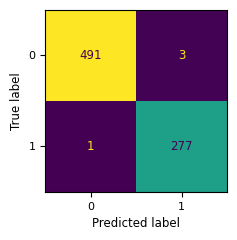

In [ ]:
# plot out confusion matrix

width_cm = 6
height_cm = 6
cm_to_inch = 2.54

fig_cm, ax_cm = plt.subplots(figsize=(width_cm/cm_to_inch, height_cm/cm_to_inch))

cm = confusion_matrix(all_true_labels, all_preds)

disp = ConfusionMatrixDisplay(cm)
disp.plot(ax=ax_cm, cmap = None, colorbar=False)

plt.show()

25
[tensor(0.1564, device='cuda:0'), tensor(0.0812, device='cuda:0'), tensor(0.0586, device='cuda:0'), tensor(0.0485, device='cuda:0'), tensor(0.0549, device='cuda:0'), tensor(0.0277, device='cuda:0'), tensor(0.0424, device='cuda:0'), tensor(0.0171, device='cuda:0'), tensor(0.0140, device='cuda:0'), tensor(0.0150, device='cuda:0'), tensor(0.0610, device='cuda:0'), tensor(0.0124, device='cuda:0'), tensor(0.0118, device='cuda:0'), tensor(0.0129, device='cuda:0'), tensor(0.0150, device='cuda:0'), tensor(0.0180, device='cuda:0'), tensor(0.0316, device='cuda:0'), tensor(0.0106, device='cuda:0'), tensor(0.0127, device='cuda:0'), tensor(0.0114, device='cuda:0'), tensor(0.0098, device='cuda:0'), tensor(0.0139, device='cuda:0'), tensor(0.0111, device='cuda:0'), tensor(0.0100, device='cuda:0'), tensor(0.0124, device='cuda:0')]


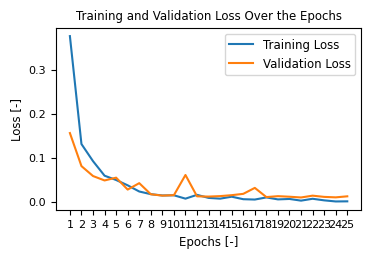

In [ ]:
# print learning curves

print(len(train_losses_best))
print(val_losses_best)

train_loss_values = [loss.item() for loss in train_losses_best]
val_loss_values = [loss.item() for loss in val_losses_best]

epochs_range = range(1, len(train_loss_values) + 1)

best_learning_curves_df = pd.DataFrame({
    "Epoch": range(1, len(train_loss_values) + 1),
    "Training Loss": train_loss_values,
    "Validation Loss": val_loss_values
})

# Set default font type and sizes
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 8.5,
    'axes.labelsize': 8.5,
    'axes.titlesize': 8.5,
    'legend.fontsize': 8.5,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

# Set figure size
fig_curves, ax_curves = plt.subplots(figsize=((10 / cm_to_inch, 6 / cm_to_inch)))

# Plotting the loss values
ax_curves.plot(epochs_range, train_loss_values, label='Training Loss')
ax_curves.plot(epochs_range, val_loss_values, label='Validation Loss')
ax_curves.set_xlabel('Epochs [-]')  # Font size set globally
ax_curves.set_ylabel('Loss [-]')     # Font size set globally
ax_curves.set_title('Training and Validation Loss Over the Epochs')  # Font size set globally
ax_curves.legend()          # Font size set globally

ax_curves.set_xticks(range(1, len(train_loss_values) + 1))

# Show the plot
plt.show()


In [ ]:
# save model

# define connector type
if dataset_id == 0:
    connector_type = "ethernet"
elif dataset_id == 2:
    connector_type = "hva280"
elif dataset_id == 4:
    connector_type = "hva630"

cwd = str(Path.cwd())

if system == "Linux" and local_system == False:
    models_dir = "drive/MyDrive/Masters_thesis_clickSense/03_Click_Detection_Model/02_savedWeights"
    models_dir_path = os.path.join(cwd, models_dir)
elif system == "Linux" and local_system == True:
    models_dir = "02_savedWeights"
    models_dir_path = os.path.join(cwd, models_dir)
elif system == "Darwin":
    models_dir = "02_savedWeights"
    models_dir_path = os.path.join(cwd, models_dir)

if not os.path.exists(models_dir_path):
    os.makedirs(models_dir_path)

# chek if there any model in the directory
model_files = [f for f in os.listdir(models_dir_path) if f.endswith('.pt')]

# sorting function for files
def sort_key_func(file_name):
        #numbers = re.findall(r'\d+', file_name)
        number = file_name.split('_')[4]
        if number:
            return int(number) if number.isdigit() else -1
            #return int(number) # return the last number in file name
        return file_name

def extract_model_number(file_name):
    try:
        #return int(file_name.split('_')[-1].split('.')[0])
        number = file_name.split('_')[4]
        if number:
            return int(number) if number.isdigit() else -1
            #return int(number) # return the last number in file name
    except ValueError:
        print("Latest model number could not be extracted")

connector_model_files = []
for i in model_files:
    if connector_type in i:
        connector_model_files.append(i)
print(len(connector_model_files))

# create file name with the highest number after the model_ prefix
if len(connector_model_files) == 0:
    highest_model_number = 0
else:
    connector_model_files.sort(key=sort_key_func)
    print(connector_model_files)
    print(extract_model_number(connector_model_files[-1]))
    highest_model_number = extract_model_number(connector_model_files[-1]) + 1

print(highest_model_number)

model_file_name = f"{connector_type}_det_model_run_{highest_model_number}_ch1_{best_training_params[0]}_ch2_{best_training_params[1]}.pt" # connector type + channel size 1 and channel size 2
confusion_matrix_file_name = f"{connector_type}_det_model_run_{highest_model_number}_ch1_{best_training_params[0]}_ch2_{best_training_params[1]}_confusion_matrix.png"
learning_curves_file_name = f"{connector_type}_det_model_run_{highest_model_number}_ch1_{best_training_params[0]}_ch2_{best_training_params[1]}_lr_{best_training_params[2]}_learning_curves.pdf"
learning_curves_file_name_csv = f"{connector_type}_det_model_run_{highest_model_number}_ch1_{best_training_params[0]}_ch2_{best_training_params[1]}_lr_{best_training_params[2]}_learning_curves.csv"

model_file_path = os.path.join(models_dir_path, model_file_name)
torch.save(best_model_weights, model_file_path) # only saving the state_dict() only saves the learned parameters

# save the results
if local_system == False:
    save_dir_training_results = "/content/drive/MyDrive/Masters_thesis_clickSense/03_Click_Detection_Model/03_trainingResults"
else:
    cwd = str(Path.cwd())
    save_dir_training_results = os.path.join(cwd, "03_trainingResults")

os.makedirs(save_dir_training_results, exist_ok=True)

save_path_confusion_matrix = os.path.join(save_dir_training_results, confusion_matrix_file_name)
save_path_learning_curves = os.path.join(save_dir_training_results, learning_curves_file_name)
save_path_learning_curves_csv = os.path.join(save_dir_training_results, learning_curves_file_name_csv)

fig_cm.savefig(save_path_confusion_matrix, format="png", dpi=200, bbox_inches="tight")
fig_curves.savefig(save_path_learning_curves, format="pdf", bbox_inches="tight")
best_learning_curves_df.to_csv(save_path_learning_curves_csv, index=False)


2
['hva630_det_model_run_0_ch1_32_ch2_64.pt', 'hva630_det_model_run_1_ch1_128_ch2_128.pt']
1
2
